In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import scipy.stats
import os

In [2]:
# Paso de latitud/longitud a coordenadas x, y en la proy. Mercator (en km)
def merc_from_arrays(lats, lons):
    r_major = 6378.137000
    x = r_major * np.radians(lons)
    scale = x/lons
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + lats * (np.pi/180.0)/2.0)) * scale
    return np.vstack((x, y)).T

In [3]:
def get_data(layer=1, info=False):
    coords = pd.read_csv('coordinate-countries-fixed.csv')
    coords = coords.rename(columns={'ISO 3166 Country Code': 'Code'})
    
    coordinates = merc_from_arrays(coords['Latitude'], coords['Longitude'])
    coords['x'] = coordinates[:, 0]
    coords['y'] = coordinates[:, 1]

    # Pongo a mano el codigo de Namibia porque anda mal
    coords.loc[coords['Country'] == 'Namibia', 'Code'] = 'NA'

    prods = eval(open("gprops-fixed.csv").read())

    nodes = pd.read_csv('nodes-fixed.csv')
    nodes = nodes.rename(columns={'# index': 'index', ' name': 'name'})
    nodes = nodes.drop(columns=[' nodeLabel', ' _pos'])
    # Reemplazo '_' con ' ' para que matcheen mas paises
    nodes['name'] = nodes['name'].str.replace('_', ' ')

    # Merge DataFrames A and B based on matching country names
    merged_nodes = pd.merge(coords, nodes, left_on='Country', right_on='name')

    # Filter and sort the merged DataFrame
    merged_nodes = merged_nodes[['index', 'Country', 'Code', 'Latitude', 'Longitude', 'x', 'y']].sort_values(by='index')
    merged_nodes.reset_index(drop=True, inplace=True)


    all_edges = pd.read_csv('edges.csv')
    all_edges = all_edges.rename(columns={'# source': 'source', ' target': 'target', ' weight': 'weight', ' layer': 'layer'})

    unique_count = all_edges[['source', 'target']].values.flatten()
    unique_count = len(set(unique_count))

    # Filtro solo un layer
    one_layer_edges = all_edges[all_edges['layer'] == layer]
    # Saco cuando source = target (que onda esto?)
    one_layer_edges = one_layer_edges[one_layer_edges['source'] != one_layer_edges['target']]
    # Filtro los paises que no estan en el dataframe (los que no tienen coordenadas)
    one_layer_edges = one_layer_edges[one_layer_edges['source'].isin(merged_nodes['index']) & one_layer_edges['target'].isin(merged_nodes['index'])]

    unique_count = one_layer_edges[['source', 'target']].values.flatten()
    unique_count = len(set(unique_count))

    if info:
        print(f"Layer {layer}: {prods[layer]}\nNumber of countries:", unique_count)

    filtered_nodes = merged_nodes[merged_nodes['index'].isin(one_layer_edges['source']) | merged_nodes['index'].isin(one_layer_edges['target'])]

    G = nx.from_pandas_edgelist(one_layer_edges, source= 'source', target = 'target')

    pos = {node : [filtered_nodes.loc[filtered_nodes['index'] == node, 'x'].values[0], filtered_nodes.loc[filtered_nodes['index'] == node, 'y'].values[0]] for node in filtered_nodes['index']}
    
    
    codes = {node : filtered_nodes.loc[filtered_nodes['index'] == node, 'Code'].values[0] for node in filtered_nodes['index']}
    
    nx.set_node_attributes(G, pos, 'pos')
    nx.set_node_attributes(G, codes, 'code')

    return G, filtered_nodes

def draw(G):
    pos = nx.get_node_attributes(G, 'pos')
    codes = nx.get_node_attributes(G, 'code')
    pos_text = {i: [v[0], v[1] - 350] for i, v in pos.items()}
    fig, ax = plt.subplots(figsize=(15,8))
    nx.draw_networkx_labels(G, pos_text, codes, font_size=10)
    nx.draw(G, pos=pos, node_size=40, width=.15, ax=ax)

Layer 137: Buffaloes
Number of countries: 2


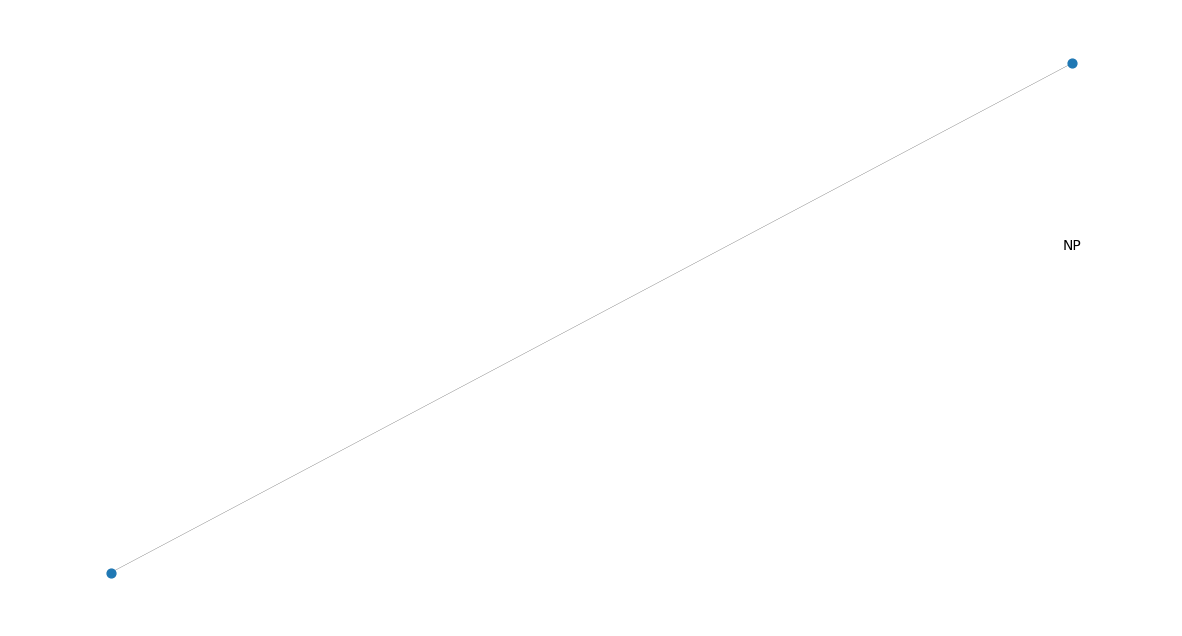

In [46]:
# Diccionario con el nombre de los productos
prods = eval(open("gprops-fixed.csv").read())

G, filtered_nodes = get_data(layer=137, info=True)

draw(G)

### Ahora podemos hacer un poco de histogramas y estadistica con las distintas layers

In [14]:
def get_mean_connectivity(G):
        return np.mean(list(dict(nx.degree(G)).values()))

def get_average_distance(G):
        Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
        G0 = G.subgraph(Gcc[0])
        return nx.average_shortest_path_length(G0)

def get_neighbors(G):
        return np.array(list(dict(nx.degree(G)).values()))

def plot_p_k(n_neighs, layer):
        fig, ax = plt.subplots(dpi=150)
        ax.set_title(prods[layer])
        ax.set_xlabel('k')
        ax.hist(n_neighs, bins=range(max(n_neighs)+1));
        # ax.set_xscale('log')
        # ax.set_yscale('log')

In [6]:
layers = prods.keys()

graphs = [get_data(layer)[0] for layer in layers]

In [7]:
connectivity = [get_mean_connectivity(G) for G in graphs]
distance = [get_average_distance(G) for G in graphs]
n_nodes = [G.number_of_nodes() for G in graphs]
n_neighs = [get_neighbors(G) for G in graphs]

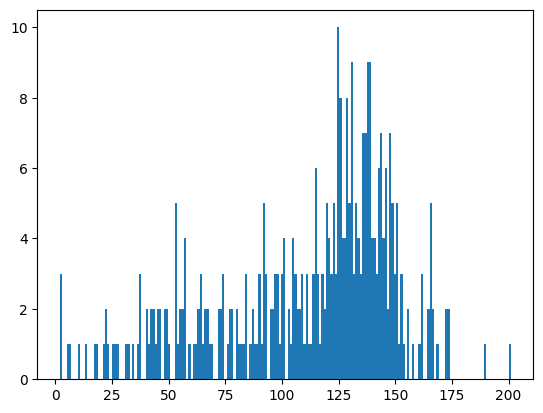

In [12]:
plt.hist(n_nodes, bins=200);

In [40]:
connectivity.index(max(connectivity))

2

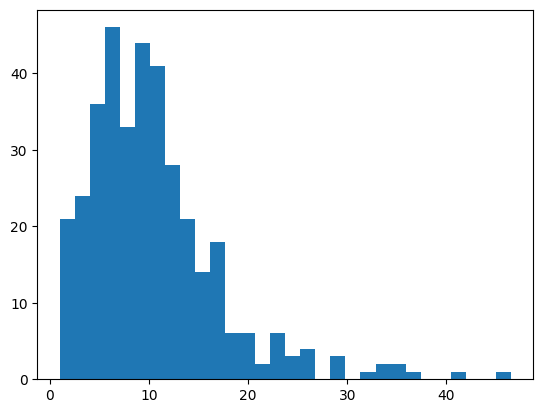

In [22]:
plt.hist(connectivity, bins=30);

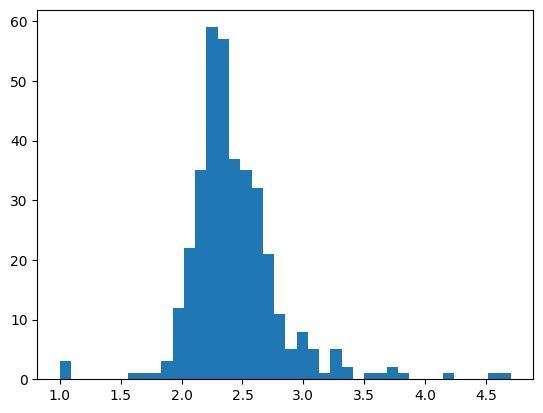

In [27]:
plt.hist(distance, bins=40);

Max nodes: 201 for product 23: Crude_materials
Min nodes: 2 for product 136: Buffaloes


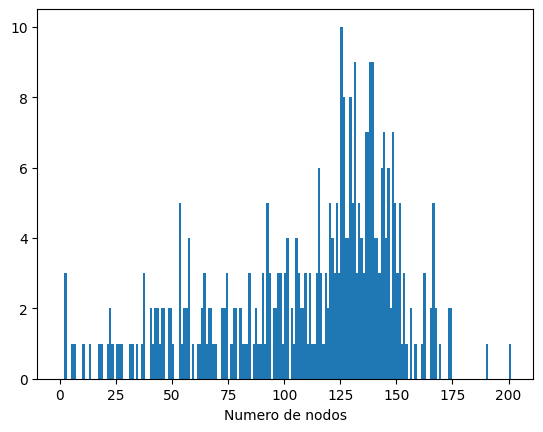

In [48]:
print(f"Max nodes: {max(n_nodes)} for product {n_nodes.index(max(n_nodes))}: {prods[n_nodes.index(max(n_nodes))+1]}")
print(f"Min nodes: {min(n_nodes)} for product {n_nodes.index(min(n_nodes))}: {prods[n_nodes.index(min(n_nodes))+1]}")
plt.xlabel('Numero de nodos')
plt.hist(n_nodes, bins=range(max(n_nodes)+1));

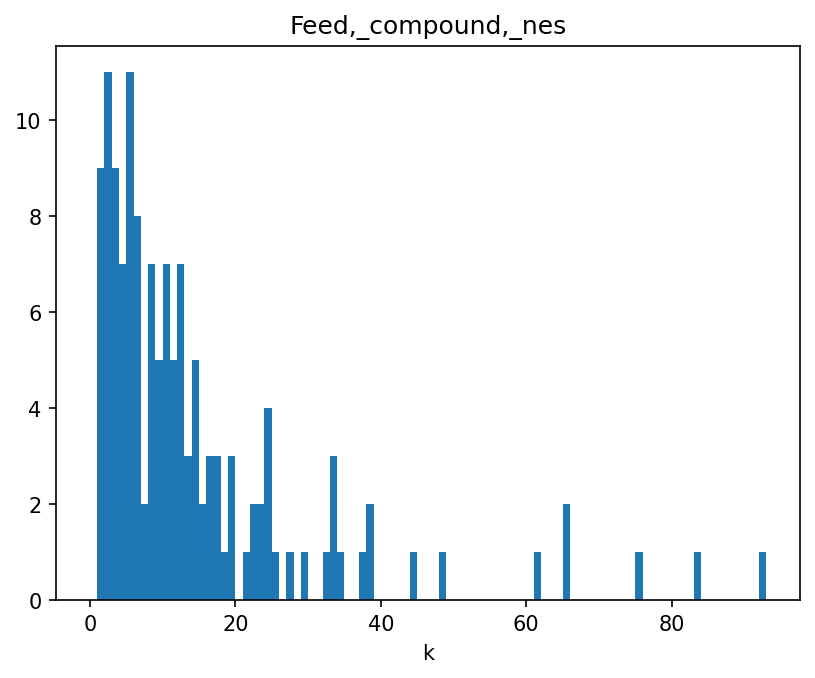

In [51]:
layer = 25
plot_p_k(n_neighs[layer], layer)

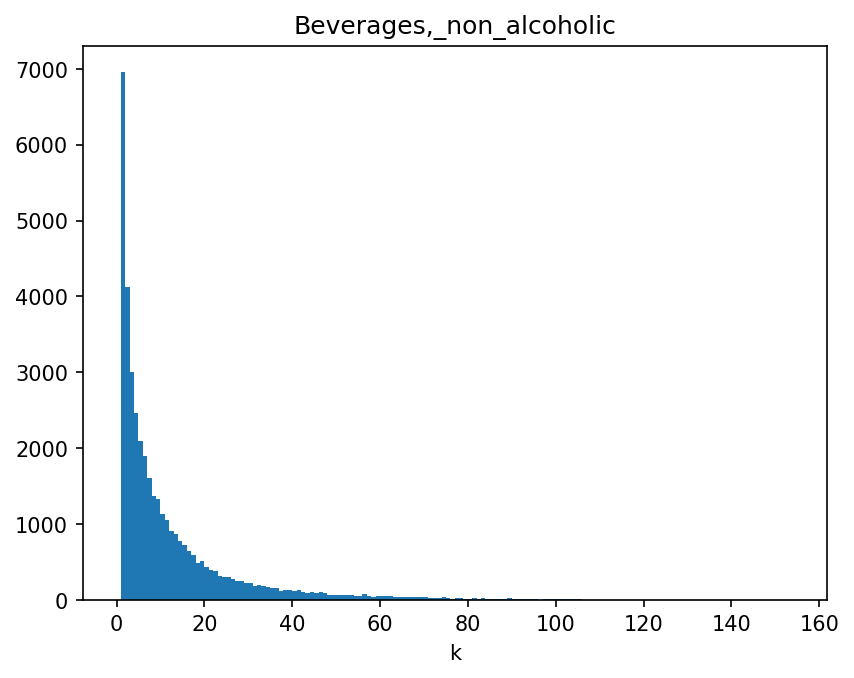

In [16]:
flat_data = [data for hist in n_neighs for data in hist]
plot_p_k(flat_data, layer=1)

(1.4800213845749386, -6.684254890176896, 7.684254890176895)
(1.0, 11.3849447376282)


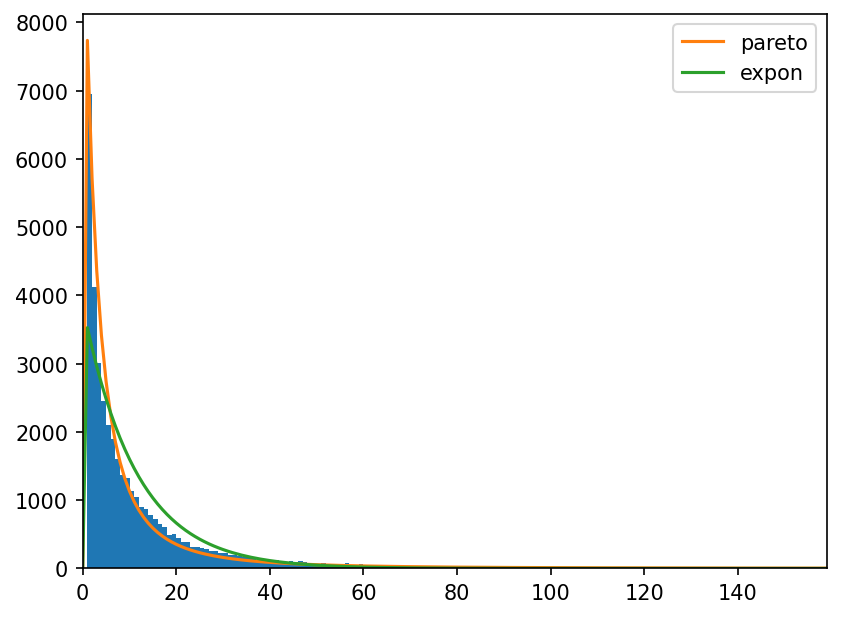

In [55]:
tail = flat_data
size = len(tail)
x = np.arange(size)
y = tail
plt.figure(dpi=150)
h = plt.hist(tail, bins=range(max(tail)+1))

dist_names = ['pareto', 'expon']
for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    params = dist.fit(y)
    loc = params[-2]
    scale = params[-1]
    if arg := params[:-2]:
        pdf_fitted = dist.pdf(x, *arg, loc=loc, scale=scale) * size
    else:
        pdf_fitted = dist.pdf(x, loc=loc, scale=scale) * size
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0, max(tail)+5)
    print(params)
plt.legend(loc='upper right')
plt.show()

## Entendiendo el fit de Pareto

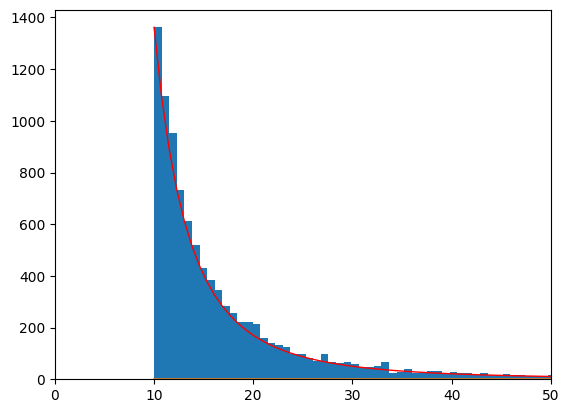

In [120]:
n_puntos = 10000
a, m = 2., 10.  # shape and mode

s = (np.random.default_rng().pareto(a, n_puntos) + 1) * m

count, bins, _ = plt.hist(s, 2000)

fit = a*m**a / bins**(a+1)#         pdf_fitted = dist.pdf(x, loc=loc, scale=scale) * size

plt.plot(bins, max(count)*fit/max(fit), linewidth=1, color='r')
plt.plot(bins, 2/bins**(a+1))
plt.xlim(0, 50)
plt.show()

(1.939824432221483, 0.27322429608675236, 9.727279715342755)

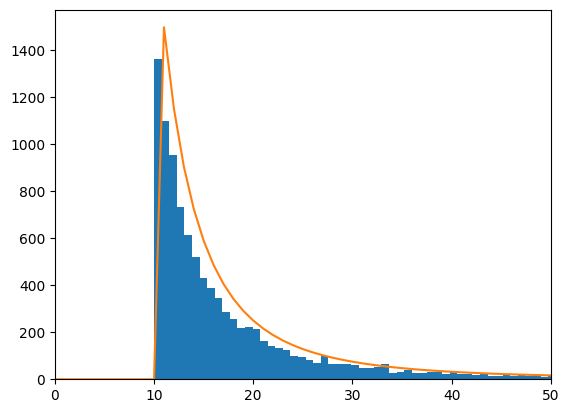

In [138]:
size = n_puntos
x = np.arange(100)
y = s
h, bins, _ = plt.hist(s, bins=2000)

pareto = scipy.stats.pareto
params = pareto.fit(y)
pdf = pareto.pdf(x, params[:-2], loc=params[-2], scale=params[-1]) * size
plt.plot(pdf)
plt.xlim(0, 50)
params